# Time to get your hands dirty! Planning a telescope observation

Let’s build your first Markov Chain!

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

which means that

$$
P(\text{clear tomorrow} \mid \text{cloudy today}) = 0.5
$$

$$
P(\text{cloudy tomorrow} \mid \text{cloudy today}) = 0.5
$$

We also have

$$
P(\text{cloudy tomorrow} \mid \text{clear today}) = 0.1
$$

which means that

$$
P(\text{clear tomorrow} \mid \text{clear today}) = 0.9
$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.  
  This will look like a big decision tree.
- After enough days, we’ll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we’ll arrive at:

$$
P(\text{clear}) = 0.83
$$

$$
P(\text{cloudy}) = 0.17
$$

You get the same answer for day \( N \) as day \( N + 1 \), and it doesn’t matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.


## Tasks

- Start off on a cloudy day.
- Implement your weather forecast based on the above probabilities.
- Run your simulation for 
  $$
  N \text{ days (with } N \geq 10^5 \text{)}
  $$
- Prepare a plot with the number of days on the x-axis and the cumulative fraction of, say, sunny days over the number of days so far on the y-axis. This is called a **trace-plot**, showing how our estimate of 
  $$
  P(\text{clear})
  $$
  evolves as the chain samples.
- Prepare a histogram of the above plot. This reveals the distribution of 
  $$
  P(\text{clear})
  $$
- Use a summary statistic to determine the most likely value and an error on our estimate.


## Important

In MCMC the process must be **stationary**, which basically means that the chain statistics look the same no matter which chunk you look at (e.g., first half, second half, or any other point, etc.)

This means that we are **not** going to get to the true value in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.

So there is a **burn-in** phase that needs to be discarded. How we determine the number of early steps to discard as burn-in is tricky, but you should always start with a traceplot of your samples!



In the above example, experiment with chopping off different numbers of initial points as burn-in.



## (Optional, not essential)

- Read the intro to Markovian Finance  
  (see the note for the Markovian process describing the stock market in this notebook. If you’ve written your code well, this should require only minor modifications.)


In [111]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import astroML.stats

In [112]:
N = 100000 #number of days, i don't put the number of days required because it will take so long
weather = 0 # 0 = rainy, 1 = sunny  ---  starting day

Prr = 0.5 #rainy today->rainy tomorrow
Prs = 0.5 #rainy today-> sunny tomorrow
Psr = 0.1 #sunny today->rainy tomorrow
Pss = 0.9 #sunny today->sunny tomorrow

Rainy = 0 #days of rain
Sunny  = 0

days = []

In [113]:
for i in range(N):
    num = np.random.uniform(0,1)
    if(weather == 0): #we are on a rainy day
        if(num < Prr): #if the generating number is less than the prob to stay in rain
            Rainy += 1 # we stay in rain
            days.append(weather)
        else: 
            Sunny += 1 # we pass to sun!
            weather = 1
            days.append(weather)
    else: #we are on a sunny day
        if(num < Psr): # twist of before
            Rainy += 1 #if the generating number is less then the prob of change, we change weather
            weather = 0
            days.append(weather)
        else:
            Sunny += 1
            days.append(1)
    
   
Ps = Sunny/N 
Pr = Rainy/N

print("The probability of Rainy days is:", Pr)
print("The probability of Sunny days is:", Ps)

The probability of Rainy days is: 0.16577
The probability of Sunny days is: 0.83423


In [114]:
def CDF(i , days): # Not exactly a CDF, but rather an estimated probability over time
    rain = 0 
    sun =  0
    for k in range(i):
        if days[k]  == 0:
            rain += 1
        if days[k] == 1:
            sun += 1
    
    return rain/i, sun/i  
#this function retrive the CDF poit for points of all my chain


In [115]:
# Function to compute the autocorrelation of a time series x at a given lag
# a lag means a delay or offset between two points in the sequence

def autocorr(x, lag):
    n = len(x)
    x = np.array(x)             # Convert to NumPy array for vectorized operations
    mean = np.mean(x)           
    var = np.var(x)             
    
    # Compute autocorrelation at given lag using the definition:
    # Cov(x_t, x_{t+lag}) / Var(x)
    return np.correlate(x[:n-lag] - mean, x[lag:] - mean)[0] / ((n - lag) * var)

# Set the maximum lag up to which to compute the autocorrelation function
max_lag = 50  

# Compute autocorrelation values for lags from 1 to max_lag - 1
autocorrs = [autocorr(days, lag) for lag in range(1, max_lag)]

# Estimate the **integrated autocorrelation time (tau_int)**:
# τ_int ≈ 1 + 2 * sum of autocorrelations for lags > 0
# This gives a measure of how many samples you need to skip to get "independent" samples
tau_int = 1 + 2 * np.sum(autocorrs)

# Print the estimated autocorrelation time
print("Estimated autocorrelation time:", tau_int)

# Thin the original chain by selecting one sample every tau_int steps
# This gives you approximately independent samples
thin_step = int(np.ceil(tau_int))  # Always round up to be conservative
thinned_days = days[::thin_step]   # Keep every tau_int-th sample


Estimated autocorrelation time: 2.332691368336901


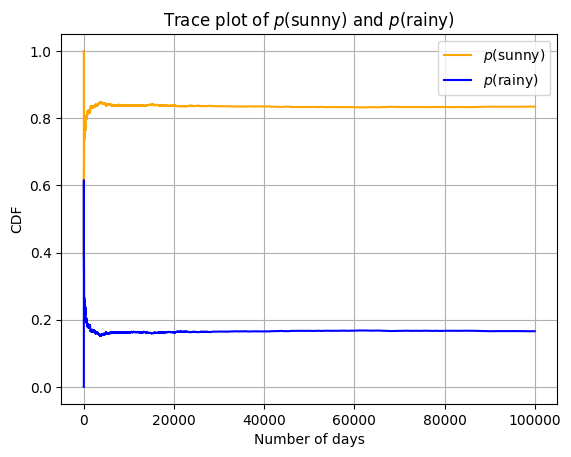

In [ ]:
sunny_days = []
rainy_days = []

for i in range(1, N + 1):
    cdf_rainy, cdf_sunny = CDF(i, days)
    rainy_days.append(cdf_rainy)
    sunny_days.append(cdf_sunny)


plt.plot(range(1, N + 1), sunny_days, label=r"$p(\mathrm{sunny})$", color='orange')
plt.plot(range(1, N + 1), rainy_days, label=r"$p(\mathrm{rainy})$", color='blue')
plt.xlabel("Number of days")
plt.ylabel("CDF")
plt.title(r"Trace plot of $p(\mathrm{sunny})$ and $p(\mathrm{rainy})$")
plt.legend()
plt.grid(True)
plt.show()

#5 minuti e 24 s

In this contest a burn in period is decided visually and choose aroun 2000

In [117]:
from astroML import stats as astroMLstats

def bins_num (X) :

    sigmaG2 = astroMLstats.sigmaG(X) # quantile at 75 - quantile at 25
    binsize = 2.7 * sigmaG2 / (len(X)**(1/3)) #Freedman-Diaconis
    N = (max(X) - min(X))/binsize

    return int(N+2)

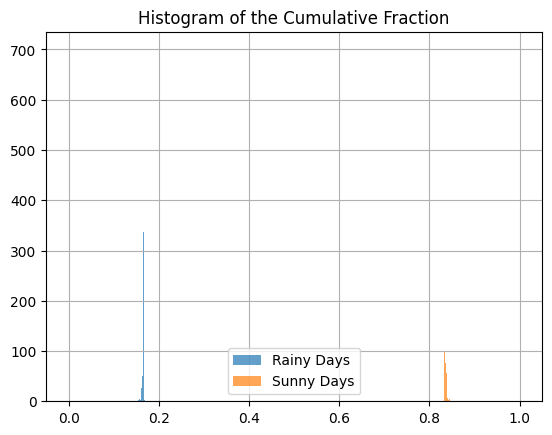

In [ ]:
plt.hist(rainy_days, bins_num(rainy_days), alpha=0.7, label="Rainy Days", density=True)
plt.hist(sunny_days, bins_num(sunny_days), alpha=0.7, label="Sunny Days", density=True)
plt.title('Histogram of the Cumulative Fraction')
plt.grid(True)
plt.legend()
plt.show()

In [119]:
mean_sunny_fraction = np.mean(sunny_days)
std_sunny_fraction = np.std(sunny_days)
mean_rainy_fraction = np.mean(rainy_days)
std_rainy_fraction = np.std(rainy_days)

print(f"Sunny probability: {mean_sunny_fraction:.4f} ± {std_sunny_fraction:.4f}")
print(f"Rainy probability: {mean_rainy_fraction:.4f} ± {std_rainy_fraction:.4f}")

Sunny probability: 0.8341 ± 0.0076
Rainy probability: 0.1659 ± 0.0076


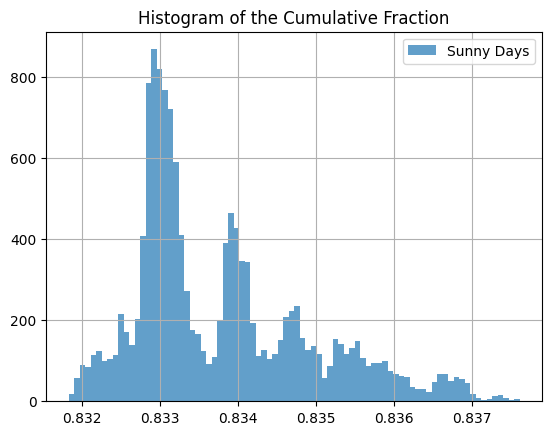

In [123]:
burn_in = 20000
s_burnin = sunny_days[burn_in:]
r_burnin = rainy_days[burn_in:]

plt.hist(s_burnin, bins_num(s_burnin), alpha=0.7, label="Sunny Days", density=True)

plt.title('Histogram of the Cumulative Fraction')
plt.grid(True)
plt.legend()
plt.show()

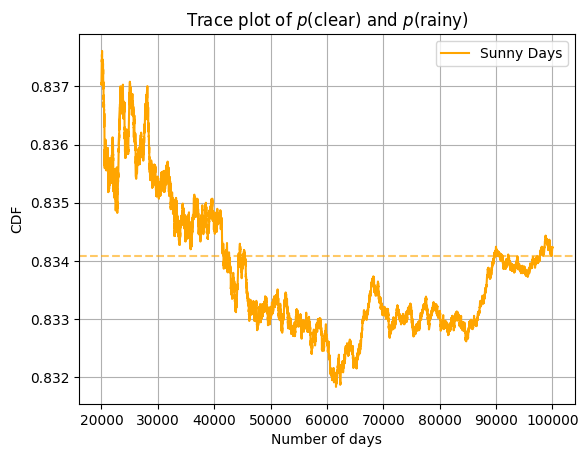

In [124]:
plt.plot(range(burn_in, burn_in + len(s_burnin)), s_burnin, label="Sunny Days", color="orange")

plt.axhline(mean_sunny_fraction, linestyle='--', color='orange', alpha=0.6)

plt.xlabel("Number of days")
plt.ylabel("CDF")
plt.title(r"Trace plot of $p(\mathrm{clear})$ and $p(\mathrm{rainy})$")
plt.legend()
plt.grid(True)
plt.show()


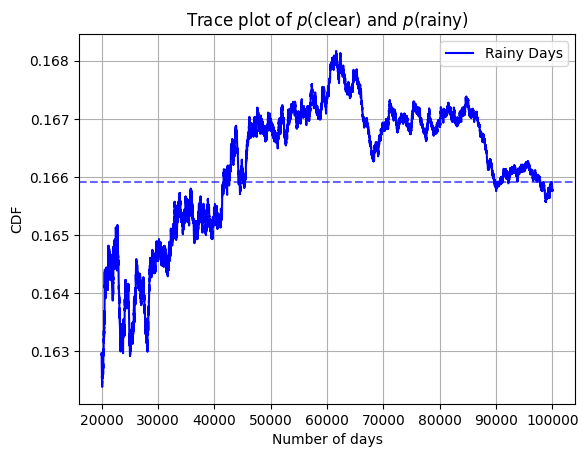

In [125]:
plt.plot(range(burn_in, burn_in + len(r_burnin)), r_burnin, label="Rainy Days", color="blue")

plt.axhline(mean_rainy_fraction, linestyle='--', color='blue', alpha=0.6)


plt.xlabel("Number of days")
plt.ylabel("CDF")
plt.title(r"Trace plot of $p(\mathrm{clear})$ and $p(\mathrm{rainy})$")
plt.legend()
plt.grid(True)
plt.show()